In [104]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [105]:
actions = [
"ㅇ_2", 
"ㅎ"
]

data = np.concatenate([
    np.load('dataset/seq_ㅇ_2_1636341560.npy'),
    np.load('dataset/seq_ㅎ_1636341560.npy')
    
], axis=0)

data.shape

(1690, 30, 79)

In [106]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(1690, 30, 78)
(1690,)


In [107]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(1690, 2)

In [108]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=42)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1521, 30, 78) (1521, 2)
(169, 30, 78) (169, 2)


In [109]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 64)                36608     
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 66        
Total params: 38,754
Trainable params: 38,754
Non-trainable params: 0
_________________________________________________________________


In [110]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model_j24.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
48/48 [==============================] - 1s 12ms/step - loss: 0.3172 - acc: 0.8619 - val_loss: 0.0116 - val_acc: 1.0000

Epoch 00001: val_acc improved from -inf to 1.00000, saving model to models\model_j24.h5
Epoch 2/200
48/48 [==============================] - 0s 9ms/step - loss: 9.3334e-04 - acc: 1.0000 - val_loss: 1.1392e-06 - val_acc: 1.0000

Epoch 00002: val_acc did not improve from 1.00000
Epoch 3/200
48/48 [==============================] - 0s 9ms/step - loss: 4.5747e-07 - acc: 1.0000 - val_loss: 8.8523e-07 - val_acc: 1.0000

Epoch 00003: val_acc did not improve from 1.00000
Epoch 4/200
48/48 [==============================] - 0s 9ms/step - loss: 3.8200e-07 - acc: 1.0000 - val_loss: 7.9142e-07 - val_acc: 1.0000

Epoch 00004: val_acc did not improve from 1.00000
Epoch 5/200
48/48 [==============================] - 0s 8ms/step - loss: 3.3529e-07 - acc: 1.0000 - val_loss: 6.9972e-07 - val_acc: 1.0000

Epoch 00005: val_acc did not improve from 1.00000
Epoch 6/200
48/48 [

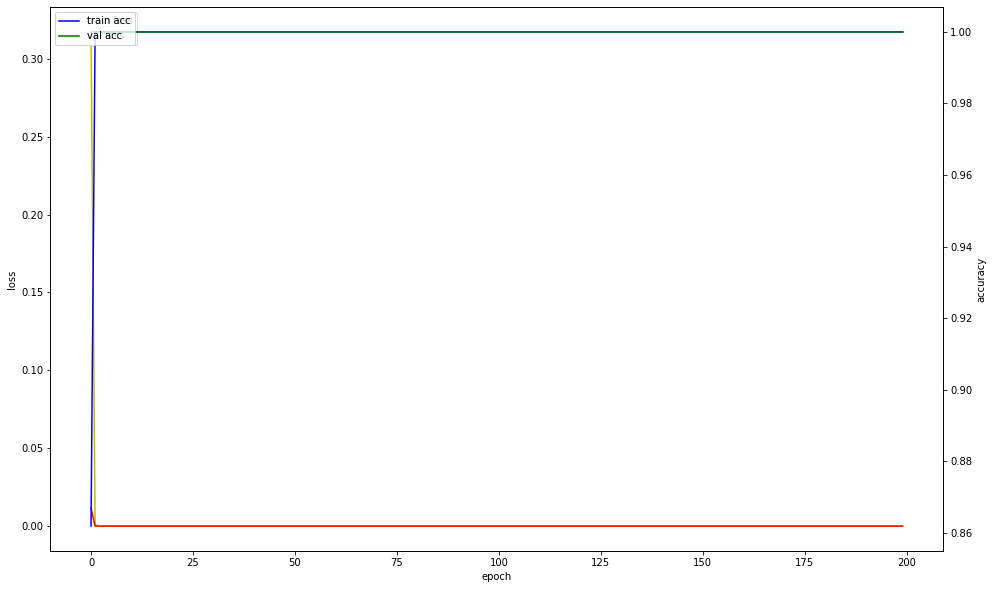

In [111]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [112]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model_j24.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[79,  0],
        [ 0, 90]],

       [[90,  0],
        [ 0, 79]]], dtype=int64)

In [113]:


import tensorflow as tf
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('models/model_j24.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\dropl\AppData\Local\Temp\tmp_xjzpbdk\assets


INFO:tensorflow:Assets written to: C:\Users\dropl\AppData\Local\Temp\tmp_xjzpbdk\assets
